In [332]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import pandas as pd
import cv2
import matplotlib.image as mpimg
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv3D, Flatten, MaxPooling2D, MaxPooling3D, Dropout, LayerNormalization, LeakyReLU, BatchNormalization, LSTM, Softmax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model, to_categorical
import graphviz
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew

In [150]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Run: Local
folder_link = ""

In [151]:
# Run: Darren
folder_link = "/content/drive/My Drive/comp4211/project/"

In [ ]:
# Run: Newt
folder_link = "/content/drive/My Drive/HKUST/COMP 4211/Project/"

In [153]:
os.listdir(f"{folder_link}image_data/adausdt")
# os.listdir('/content/drive/My Drive/HKUST/COMP 4211/Project/image_data/adausdt')

['validation_output.csv',
 'validation_data.dat',
 'training_output.csv',
 'training_data.dat',
 'testing_output.csv',
 'testing_data.dat',
 'adausdt_btcusdt_training_images.npz',
 'adausdt_btcusdt_testing_images.npz',
 'adausdt_btcusdt_validation_images.npz']

## Data Processing

In [4]:
# train_data = np.load(f"{folder_link}image_data/train_data.npz")["arr_0"]
# train_output = pd.read_csv(f"{folder_link}image_data/train_output.csv")
# test_data = np.load(f"{folder_link}image_data/test_data.npz")["arr_0"]
# test_output = pd.read_csv(f"{folder_link}image_data/test_output.csv")

In [245]:
# train_data = []
# test_data = []
# for coin in coins:
#     train_data.append(np.concatenate([np.load(f"{folder_link}image_data/merge/{coin}usdt_btcusdt_training_images.npz")["images"],
#                                       np.load(f"{folder_link}image_data/merge/{coin}usdt_btcusdt_validation_images.npz")["images"]]))

#     test_data.append(np.load(f"{folder_link}image_data/merge/{coin}usdt_btcusdt_testing_images.npz")["images"])

# train_data = np.array(train_data) #.reshape(-1, 2, 54, 72)
# test_data = np.array(test_data)

# np.savez_compressed(f"{folder_link}image_data/merge_processed/train_data.npz", images = train_data)
# np.savez_compressed(f"{folder_link}image_data/merge_processed/test_data.npz", images = test_data)

In [308]:
coins = ['doge', 'dot', 'eth', 'sol'] + ['ltc', 'bnb', 'trx', 'xlm', 'uni']

train_data = np.load(f"{folder_link}image_data/merge_processed/train_data.npz")["images"]
test_data = np.load(f"{folder_link}image_data/merge_processed/test_data.npz")["images"]
train_data = np.concatenate(train_data, axis=0)
test_data = np.concatenate(test_data, axis=0)

train_output = []
test_output = []
for coin in coins:
    train_output.append(pd.concat([pd.read_csv(f"{folder_link}image_data/{coin}usdt/training_output.csv"),
                                   pd.read_csv(f"{folder_link}image_data/{coin}usdt/validation_output.csv")]))

    test_output.append(pd.read_csv(f"{folder_link}image_data/{coin}usdt/testing_output.csv"))

for i in range(len(train_output)):
    train_output[i] = train_output[i].reset_index().drop(columns=["index"])
    train_output[i].drop(columns=["High", "Low", "Volume", "Close time", "Quote asset volume", "Number of trades", "Taker buy base asset volume", "Taker buy quote asset volume"], inplace=True)
    test_output[i] = test_output[i].reset_index().drop(columns=["index"])
    test_output[i].drop(columns=["High", "Low", "Volume", "Close time", "Quote asset volume", "Number of trades", "Taker buy base asset volume", "Taker buy quote asset volume"], inplace=True)

train_output = pd.DataFrame(np.concatenate(train_output, axis=0))
test_output = pd.DataFrame(np.concatenate(test_output, axis=0))
train_output.columns = ["Timestamp", "LogReturns"]
test_output.columns = ["Timestamp", "LogReturns"]

In [309]:
train_output

,Timestamp,LogReturns
0,1.609546e+12,0.020752
1,1.609549e+12,-0.009913
2,1.609553e+12,0.093061
3,1.609556e+12,0.051327
4,1.609560e+12,0.158466
...,...,...
255595,1.711908e+12,0.003542
255596,1.711912e+12,0.000000
255597,1.711915e+12,0.000845
255598,1.711919e+12,-0.005931


(255600, 2, 54, 72)
(45999, 2, 54, 72)


Text(0.5, 1.0, 'BTC')

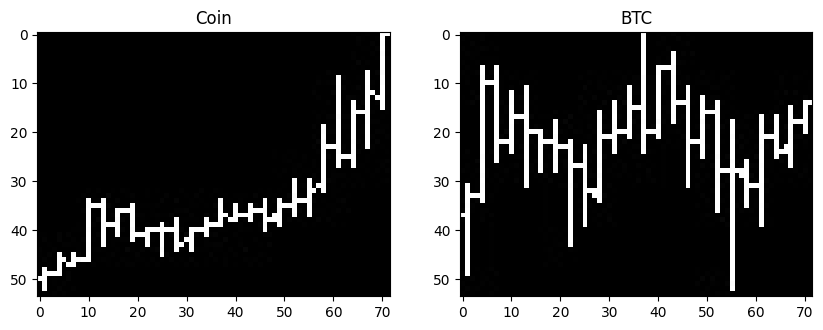

In [321]:
print(train_data.shape)
print(test_data.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(train_data[0][0], cmap='gray')
axes[0].set_title('Coin')
axes[1].imshow(train_data[0][1], cmap='gray')
axes[1].set_title('BTC')

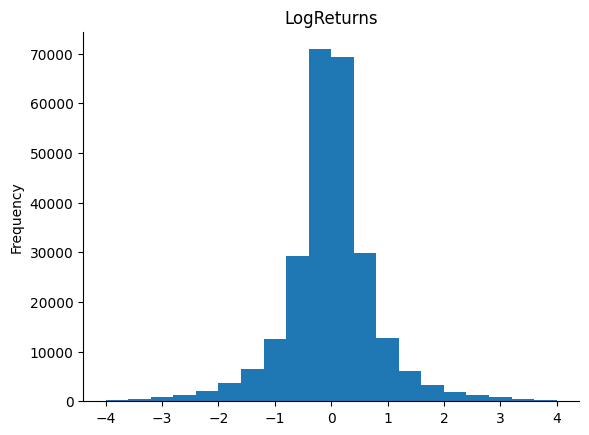

In [323]:
scaler = StandardScaler()
train_output[["LogReturns"]] = scaler.fit_transform(train_output[["LogReturns"]])

train_output['LogReturns'].plot(kind='hist', bins=20, title='LogReturns', range=(-4, 4))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [324]:
signs = np.sign(train_output["LogReturns"]).values
unique, counts = np.unique(signs, return_counts=True)
print(unique, counts)
print(counts[1] / (counts[0] + counts[1]))

[-1.  1.] [128554 127046]
0.49705007824726133


## Model

In [417]:
model = Sequential([
    # Layer 1
    Conv3D(64, kernel_size=(1, 5, 5), padding='same', dilation_rate=(1, 3, 1), input_shape=(2, 54, 72, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),
    MaxPooling3D(pool_size=(1, 2, 2)),

    # Layer 2
    Conv3D(128, kernel_size=(1, 5, 3), padding='same', dilation_rate=(1, 3, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),
    MaxPooling3D(pool_size=(1, 2, 1)),

    # Layer 3
    Conv3D(256, kernel_size=(1, 3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),
    MaxPooling3D(pool_size=(1, 2, 1)),
    Dropout(0.5),

    # FC and Output
    Flatten(),
    Dense(2, activation='softmax'),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_29 (Conv3D)                   │ (None, 2, 54, 72, 64)       │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_160              │ (None, 2, 54, 72, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_160 (LeakyReLU)          │ (None, 2, 54, 72, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_22 (MaxPooling3D)      │ (None, 2, 27, 36, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_30 (Conv3D)                   │ (None, 2, 27, 36, 128)      │         123,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_161              │ (None, 2, 27, 36, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_161 (LeakyReLU)          │ (None, 2, 27, 36, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_23 (MaxPooling3D)      │ (None, 2, 13, 36, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_31 (Conv3D)                   │ (None, 2, 13, 36, 256)      │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_162              │ (None, 2, 13, 36, 256)      │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_162 (LeakyReLU)          │ (None, 2, 13, 36, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_24 (MaxPooling3D)      │ (None, 2, 6, 36, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 2, 6, 36, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_52 (Flatten)                 │ (None, 110592)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 2)                   │         221,186 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 642,818 (2.45 MB)

 Trainable params: 641,922 (2.45 MB)

 Non-trainable params: 896 (3.50 KB)

In [419]:
X = train_data.reshape((-1, 2, 54, 72, 1))
y = train_output["LogReturns"].values
y = to_categorical(np.where(y < 0, 0, 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.fit(X, y, epochs=20, validation_split=0.2, shuffle=True, callbacks=[early_stopping])

model.save('model.h5')
loaded_model = keras.models.load_model('model.h5')

Epoch 1/20
6390/6390 ━━━━━━━━━━━━━━━━━━━━ 135s 21ms/step - accuracy: 0.5067 - loss: 1.5876 - val_accuracy: 0.5185 - val_loss: 0.7003
Epoch 2/20
6390/6390 ━━━━━━━━━━━━━━━━━━━━ 129s 20ms/step - accuracy: 0.5126 - loss: 0.7055 - val_accuracy: 0.5235 - val_loss: 0.6933
Epoch 3/20
6390/6390 ━━━━━━━━━━━━━━━━━━━━ 129s 20ms/step - accuracy: 0.5240 - loss: 0.7025 - val_accuracy: 0.5448 - val_loss: 0.6870
Epoch 4/20
6390/6390 ━━━━━━━━━━━━━━━━━━━━ 129s 20ms/step - accuracy: 0.5375 - loss: 0.6987 - val_accuracy: 0.5410 - val_loss: 0.6897
Epoch 5/20
6390/6390 ━━━━━━━━━━━━━━━━━━━━ 130s 20ms/step - accuracy: 0.5557 - loss: 0.6915 - val_accuracy: 0.5846 - val_loss: 0.6711
Epoch 6/20
6390/6390 ━━━━━━━━━━━━━━━━━━━━ 129s 20ms/step - accuracy: 0.5778 - loss: 0.6806 - val_accuracy: 0.6071 - val_loss: 0.6591
Epoch 7/20
6390/6390 ━━━━━━━━━━━━━━━━━━━━ 129s 20ms/step - accuracy: 0.6123 - loss: 0.6601 - val_accuracy: 0.6154 - val_loss: 0.6521
Epoch 8/20
6390/6390 ━━━━━━━━━━━━━━━━━━━━ 129s 20ms/step - accuracy: 

In [428]:
X_test = test_data.reshape((-1, 2, 54, 72, 1))
y_test = np.where(test_output["LogReturns"] > 0, 1, -1)

y_pred = model.predict(X_test)
y_pred_pos = y_pred[:, 0] - y_pred[:, 1]
# y_pred_pos -= y_pred_pos.mean()
y_pred_dir = np.sign(y_pred_pos)
# y_pred_dir = np.argmax(y_pred, axis=1) * 2 - 1

accuracy = np.mean(y_pred_dir == y_test)
print(f"Accuracy: {accuracy:.4f}")

1438/1438 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Accuracy: 0.4950


In [429]:
values, counts = np.unique(y_pred_dir, return_counts=True)
print(values, counts)

[-1.  1.] [22629 23370]


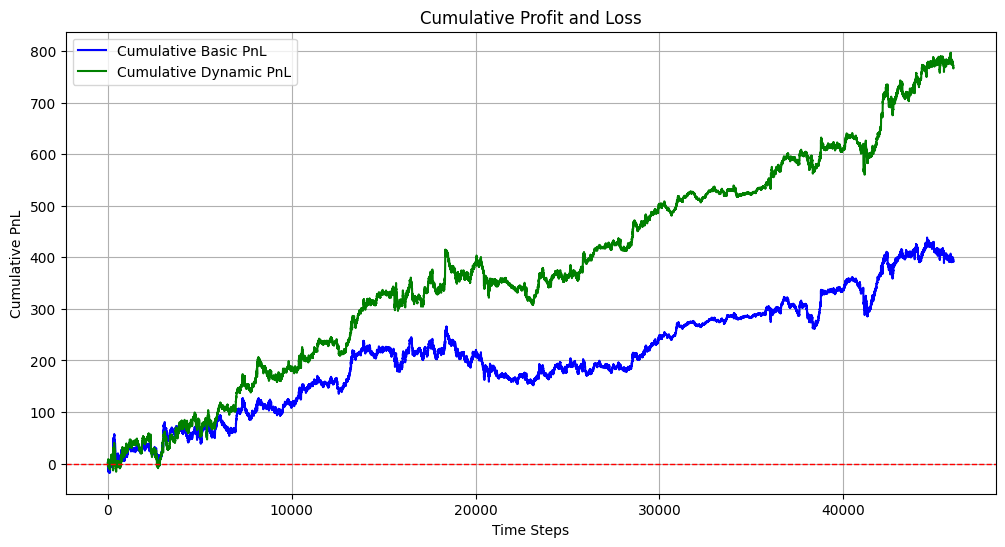

In [430]:
basic_pnl = np.array([])
for guess, change in zip(y_pred_dir, test_output["LogReturns"].values):
    basic_pnl = np.append(basic_pnl, guess * change)
cumulative_basic_pnl = np.cumsum(basic_pnl)

scaling_factor = np.mean(np.abs(y_pred_pos))
dynamic_pnl = np.array([])
for guess, change in zip(y_pred_pos, test_output["LogReturns"].values):
    dynamic_pnl = np.append(dynamic_pnl, guess * change / scaling_factor)
cumulative_dynamic_pnl = np.cumsum(dynamic_pnl)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_basic_pnl, label='Cumulative Basic PnL', color='blue')
plt.plot(cumulative_dynamic_pnl, label='Cumulative Dynamic PnL', color='green')
plt.title('Cumulative Profit and Loss')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative PnL')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.grid()
plt.show()

In [431]:
# Sharpe Ratios
print("Basic Strategy Sharpe:  ", basic_pnl.mean() / basic_pnl.std() * np.sqrt(24 * 365))
print("Dynamic Strategy Sharpe:", dynamic_pnl.mean() / dynamic_pnl.std() * np.sqrt(24 * 365))

Basic Strategy Sharpe:   0.7962195438140652
Dynamic Strategy Sharpe: 1.3402203301754487


In [432]:
pnl.mean() / pnl.std() * np.sqrt(24 * 365)

1.353720191102286